In [1]:
import ta
import optuna
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
np.random.seed(42)
warnings.filterwarnings("ignore")

In [2]:
from dataclasses import dataclass

@dataclass
class Position:
    """ A cool representation of a position
    """
    ticker: str
    n_shares: int
    price: float
    sl: float
    tp: float
    deposit: float
    time: str

In [3]:
def get_portfolio_value(cash: float, long_ops: list[Position], short_ops: list[Position], current_price: float, 
                        n_shares: int, COM: float, INITIAL_MARGIN: float) -> float:
    
    val = cash 

    # Longs
    val += len(long_ops) * current_price * n_shares * (1 - COM)

    # Shorts
    short_val = sum(
        pos.price * pos.n_shares * INITIAL_MARGIN + (pos.price - current_price) * pos.n_shares * (1 - COM) + pos.deposit
        for pos in short_ops
    )

    return val + short_val

In [4]:
data = pd.read_csv('aapl_5m_train.csv').dropna()

## <font color='cornflowerblue'> Optimización de hiperparámetros

In [5]:
def backtest(data, trial) -> float:
    data = data.copy()

    # Hyperparameters to optimize
    rsi_window = trial.suggest_int('rsi_window', 5, 50)
    rsi_lower = trial.suggest_int('rsi_lower', 5, 35)
    rsi_upper = trial.suggest_int('rsi_upper', 65, 95)
    stop_loss = trial.suggest_float('stop_loss', 0.01, 0.15)
    take_profit = trial.suggest_float('take_profit', 0.01, 0.15)
    n_shares = trial.suggest_int('n_shares', 50, 500)

    # Indicators
    rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=rsi_window)
    data['rsi'] = rsi_indicator.rsi()

    # Signals
    data['buy_signal'] = data.rsi < rsi_lower
    data['sell_signal'] = data.rsi > rsi_upper

    # Initial values
    capital: float = 1_000_000
    margin_account: float = 0
    portfolio_value = [capital]
    active_long_positions: list[Position] = []
    active_short_positions: list[Position] = []

    # Commissions and rates
    COM: float = 0.125 / 100
    BORROW_RATE: float = 0.25 / 100
    INITIAL_MARGIN = 1.5
    MAINTENANCE_MARGIN = 0.25

    # Convert annualized borrow rate to 5-min bar rate
    bars_per_year = 252 * 6.5 * 60 / 5  # 252 trading days, 6.5 hours per day, 5-min bars
    bar_borrow_rate = BORROW_RATE / bars_per_year

    # Strategy parameters
    STOP_LOSS: float = stop_loss
    TAKE_PROFIT: float = take_profit
    N_SHARES: int = n_shares

    for i, row in data.iterrows():
        # -- LONG -- #
        # Check active orders
        for position in active_long_positions.copy():
            # Stop loss or take profit check
            if row.Close > position.tp or row.Close < position.sl:
                # Add profits / losses to capital
                capital += row.Close * position.n_shares * (1 - COM)
                # Remove position from active position
                active_long_positions.remove(position)

        equity: float = 0.0
        required_equity: float = 0.0

        # -- SHORT -- #
        for position in active_short_positions.copy():
            # Apply borrow rate to active short positions
            cover_cost = row.Close * position.n_shares
            initial_account = position.price * position.n_shares * INITIAL_MARGIN
            borrow_cost = cover_cost * bar_borrow_rate

            capital -= borrow_cost
            equity += initial_account - cover_cost + position.deposit
            required_equity += MAINTENANCE_MARGIN * cover_cost
            #required_equity += MAINTENANCE_MARGIN * row.Close * position.n_shares

        for position in active_short_positions.copy():
            # Check Margin call
            if equity < required_equity:
                # Margin Call
                deposit = (required_equity - equity) * 2
                if capital > deposit:
                    print(f'Margin Call at {row.Datetime} | Equity: {equity:.2f} | Required Equity: {required_equity:.2f} | Deposit: {deposit:.2f}')
                    capital -= deposit
                    equity += deposit
                    position.deposit += deposit

                else:
                    # We have to close the position
                    print(f'Forced Close at {row.Datetime} | Equity: {equity:.2f} | Required Equity: {required_equity:.2f} | Deposit Needed: {deposit:.2f} | Capital: {capital:.2f} \n')
                    pnl = (position.price - row.Close) * position.n_shares * (1 - COM)
                    capital += pnl + position.price * position.n_shares * INITIAL_MARGIN + position.deposit

                    equity -= position.price * position.n_shares * INITIAL_MARGIN - row.Close * position.n_shares + position.deposit
                    required_equity -= MAINTENANCE_MARGIN * row.Close * position.n_shares
                    active_short_positions.remove(position)
                    continue

            if row.Close < position.tp or row.Close > position.sl:
                # Add profits / losses to capital
                pnl = (position.price - row.Close) * position.n_shares * (1 - COM)
                capital += pnl + position.price * position.n_shares * INITIAL_MARGIN + position.deposit

                equity -= position.price * position.n_shares * INITIAL_MARGIN - row.Close * position.n_shares + position.deposit
                required_equity -= MAINTENANCE_MARGIN * row.Close * position.n_shares
                active_short_positions.remove(position)
                continue

        # Check Long Signal
        if getattr(row, "buy_signal", False):
            cost = row.Close * N_SHARES * (1 + COM)

            # Do we have enough cash?
            if capital > cost:
                # Discount cash
                capital -= cost
                # Add position to portfolio
                pos = Position(ticker='AAPL', n_shares=N_SHARES, price=row.Close,
                            sl=row.Close * (1 - STOP_LOSS), tp=row.Close*(1 + TAKE_PROFIT),
                            deposit=0, time=row.Datetime)
                active_long_positions.append(pos)

        # Check Short Signal
        if getattr(row, "sell_signal", False):
            margin_requirement = row.Close * N_SHARES * INITIAL_MARGIN
            commission = row.Close * N_SHARES * COM

            # Do we have enough cash?
            if capital > margin_requirement:
                # Discount cash
                capital -= margin_requirement + commission
                # Add position to portfolio
                pos = Position(ticker='AAPL', n_shares=N_SHARES, price=row.Close,
                            sl=row.Close * (1 + STOP_LOSS), tp=row.Close*(1 - TAKE_PROFIT),
                            deposit=0, time=row.Datetime)
                active_short_positions.append(pos)

        # Calculate portfolio value
        portfolio_value.append(get_portfolio_value(capital, active_long_positions, active_short_positions, row.Close, N_SHARES, COM, INITIAL_MARGIN))
        continue
    # At the end of the backtesting, we should close all active positions
    capital += row.Close * len(active_long_positions) * N_SHARES * (1 - COM)

    for position in active_short_positions:
        pnl = (position.price - row.Close) * position.n_shares * (1 - COM)
        capital += pnl + position.price * N_SHARES * INITIAL_MARGIN + position.deposit
        equity -= position.price * position.n_shares * INITIAL_MARGIN - row.Close * position.n_shares + position.deposit
        required_equity -= MAINTENANCE_MARGIN * row.Close * position.n_shares

    active_long_positions = []
    active_short_positions = []

    return capital / 1_000_000 - 1

In [6]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: backtest(data, trial), n_trials=10, n_jobs=-1)

[I 2025-09-21 20:07:01,085] A new study created in memory with name: no-name-aa9f5d5f-b054-46aa-8d2c-f24adfe4a51b
[I 2025-09-21 20:07:06,944] Trial 7 finished with value: -0.0030492861797428716 and parameters: {'rsi_window': 35, 'rsi_lower': 22, 'rsi_upper': 89, 'stop_loss': 0.031179241096817623, 'take_profit': 0.09097517923761667, 'n_shares': 373}. Best is trial 7 with value: -0.0030492861797428716.
[I 2025-09-21 20:07:11,370] Trial 5 finished with value: 0.019749249248738332 and parameters: {'rsi_window': 49, 'rsi_lower': 14, 'rsi_upper': 71, 'stop_loss': 0.0977028516446781, 'take_profit': 0.0961871935756484, 'n_shares': 463}. Best is trial 5 with value: 0.019749249248738332.
[I 2025-09-21 20:07:18,521] Trial 1 finished with value: -0.042652074734975454 and parameters: {'rsi_window': 15, 'rsi_lower': 5, 'rsi_upper': 82, 'stop_loss': 0.11341694385333613, 'take_profit': 0.04335843312438427, 'n_shares': 228}. Best is trial 5 with value: 0.019749249248738332.
[I 2025-09-21 20:07:18,819] 

## <font color='cornflowerblue'> Resultados

In [7]:
study.best_params

{'rsi_window': 22,
 'rsi_lower': 20,
 'rsi_upper': 80,
 'stop_loss': 0.08907191258138884,
 'take_profit': 0.0762070213257723,
 'n_shares': 350}

In [8]:
study.best_value

0.2488768434144959

## <font color='cornflowerblue'> Uso de resultados óptimos

In [9]:
# Windows
window = study.best_params['rsi_window']
lower = study.best_params['rsi_lower']
upper = study.best_params['rsi_upper']

# Commissions and rates
COM = 0.125 / 100
BORROW_RATE = 0.25 / 100
INITIAL_MARGIN = 1.5
MAINTENANCE_MARGIN = 0.25

# Convert annualized borrow rate to 5-min bar rate
bars_per_year = 252 * 6.5 * 60 / 5  # 252 trading days, 6.5 hours per day, 5-min bars
bar_borrow_rate = BORROW_RATE / bars_per_year

# Strategy parameters
STOP_LOSS: float = study.best_params['stop_loss']
TAKE_PROFIT: float = study.best_params['take_profit']
N_SHARES: int = study.best_params['n_shares']

In [10]:
# Data
data = pd.read_csv('aapl_5m_train.csv').dropna()

# Indicators
rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=window)
data['rsi'] = rsi_indicator.rsi()

# Signals
data['buy_signal'] = data['rsi'] < lower
data['sell_signal'] = data['rsi'] > upper

## <font color='cornflowerblue'> Backtest

In [12]:
capital: float = 1_000_000
margin_account: float = 0.0

portfolio_value = [capital]
active_long_positions: list[Position] = []
active_short_positions: list[Position] = []

for i, row in data.iterrows():
    # -- LONG -- #
    # Check active orders
    for position in active_long_positions.copy():
        # Stop loss or take profit check
        if row.Close > position.tp or row.Close < position.sl:
            # Add profits / losses to capital
            capital += row.Close * position.n_shares * (1 - COM)
            # Remove position from active position
            active_long_positions.remove(position)

    equity: float = 0.0
    required_equity: float = 0.0

    # -- SHORT -- #
    for position in active_short_positions.copy():
        # Apply borrow rate to active short positions
        cover_cost = row.Close * position.n_shares
        initial_account = position.price * position.n_shares * INITIAL_MARGIN
        borrow_cost = cover_cost * bar_borrow_rate

        capital -= borrow_cost
        equity += initial_account - cover_cost + position.deposit
        required_equity += MAINTENANCE_MARGIN * cover_cost
        #required_equity += MAINTENANCE_MARGIN * row.Close * position.n_shares

    for position in active_short_positions.copy():
        # Check Margin call
        if equity < required_equity:
            # Margin Call
            deposit = (required_equity - equity) * 2
            if capital > deposit:
                print(f'Margin Call at {row.Datetime} | Equity: {equity:.2f} | Required Equity: {required_equity:.2f} | Deposit: {deposit:.2f}')
                capital -= deposit
                equity += deposit
                position.deposit += deposit

            else:
                # We have to close the position
                print(f'Forced Close at {row.Datetime} | Equity: {equity:.2f} | Required Equity: {required_equity:.2f} | Deposit Needed: {deposit:.2f} | Capital: {capital:.2f} \n')
                pnl = (position.price - row.Close) * position.n_shares * (1 - COM)
                capital += pnl + position.price * position.n_shares * INITIAL_MARGIN + position.deposit

                equity -= position.price * position.n_shares * INITIAL_MARGIN - row.Close * position.n_shares + position.deposit
                required_equity -= MAINTENANCE_MARGIN * row.Close * position.n_shares
                active_short_positions.remove(position)
                continue

        if row.Close < position.tp or row.Close > position.sl:
            # Add profits / losses to capital
            pnl = (position.price - row.Close) * position.n_shares * (1 - COM)
            capital += pnl + position.price * position.n_shares * INITIAL_MARGIN + position.deposit

            equity -= position.price * position.n_shares * INITIAL_MARGIN - row.Close * position.n_shares + position.deposit
            required_equity -= MAINTENANCE_MARGIN * row.Close * position.n_shares
            active_short_positions.remove(position)
            continue

    # Check Long Signal
    if getattr(row, "buy_signal", False):
        cost = row.Close * N_SHARES * (1 + COM)

        # Do we have enough cash?
        if capital > cost:
            # Discount cash
            capital -= cost
            # Add position to portfolio
            pos = Position(ticker='AAPL', n_shares=N_SHARES, price=row.Close,
                           sl=row.Close * (1 - STOP_LOSS), tp=row.Close*(1 + TAKE_PROFIT),
                           deposit=0, time=row.Datetime)
            active_long_positions.append(pos)

    # Check Short Signal
    if getattr(row, "sell_signal", False):
        margin_requirement = row.Close * N_SHARES * INITIAL_MARGIN
        commission = row.Close * N_SHARES * COM

        # Do we have enough cash?
        if capital > margin_requirement:
            # Discount cash
            capital -= margin_requirement + commission
            # Add position to portfolio
            pos = Position(ticker='AAPL', n_shares=N_SHARES, price=row.Close,
                           sl=row.Close * (1 + STOP_LOSS), tp=row.Close*(1 - TAKE_PROFIT),
                           deposit=0, time=row.Datetime)
            active_short_positions.append(pos)

    # Calculate portfolio value
    portfolio_value.append(get_portfolio_value(capital, active_long_positions, active_short_positions, row.Close, N_SHARES, COM, INITIAL_MARGIN))
    continue
# At the end of the backtesting, we should close all active positions
capital += row.Close * len(active_long_positions) * N_SHARES * (1 - COM)

for position in active_short_positions:
    pnl = (position.price - row.Close) * position.n_shares * (1 - COM)
    capital += pnl + position.price * N_SHARES * INITIAL_MARGIN + position.deposit
    equity -= position.price * position.n_shares * INITIAL_MARGIN - row.Close * position.n_shares + position.deposit
    required_equity -= MAINTENANCE_MARGIN * row.Close * position.n_shares

active_long_positions = []
active_short_positions = []

In [13]:
capital

1248876.843414496

## <font color='cornflowerblue'> Plots

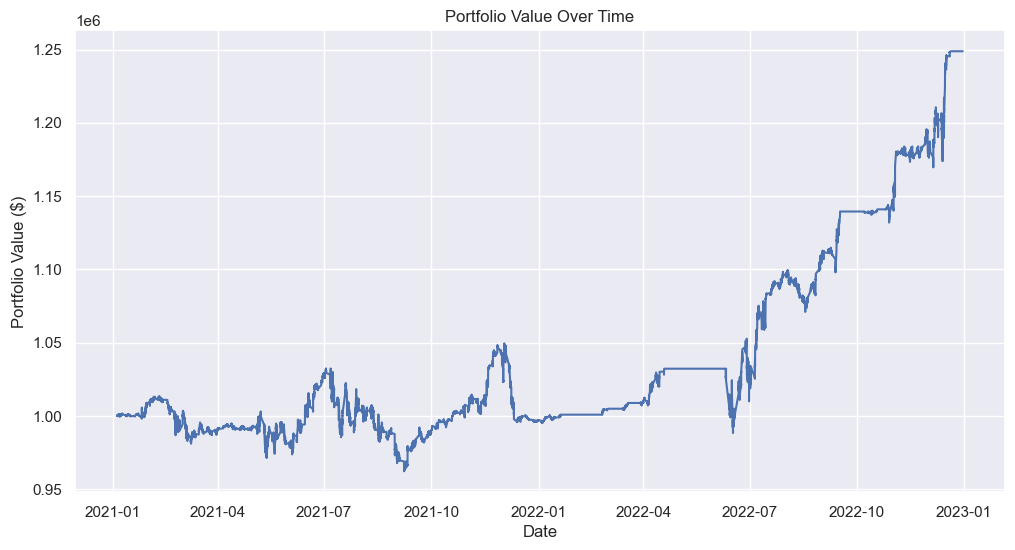

In [14]:
df = pd.DataFrame({'Portfolio Value': portfolio_value[1:]},
                  index=pd.to_datetime(data.Datetime))

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Portfolio Value'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.show()